In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
# import scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Part 1 - EDA:

In [2]:
os.listdir(path='.')

['.gitignore',
 '.ipynb_checkpoints',
 'Data Science Take-Home Challenge - Ultimate Inc.ipynb',
 'logins.json',
 'ultimate_data_challenge.json',
 'ultimate_data_science_challenge (1).pdf']

In [3]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins_df[-5:]

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


**Note:** Data covers 1/1/1970 - 4/13/1970<br>(3 months, 12 days)

In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


**Note:** 'login_time' already in datetime64 format

In [6]:
logins_df.duplicated().sum() # number of duplicates we need to drop

877

In [7]:
logins_df[logins_df.duplicated(keep=False)].head(10)
# duplicates listed together (first 2 duplicate pairs are 7 logins apart and the following 3 are 3 logins apart)
# May be intentionally-generated duplicates

,login_time
347,1970-01-02 10:59:52
354,1970-01-02 10:59:52
427,1970-01-02 12:27:48
434,1970-01-02 12:27:48
503,1970-01-02 15:08:27
506,1970-01-02 15:08:27
521,1970-01-02 16:14:36
524,1970-01-02 16:14:36
669,1970-01-02 22:03:36
672,1970-01-02 22:11:16


In [8]:
df_clean = logins_df.drop_duplicates() # keeping first occurence by default (keep='first')
df_clean = df_clean.sort_values(by='login_time') # to be sure
df_clean.count()

login_time    92265
dtype: int64

In [9]:
df_clean.loc[:,'count'] = 1.0
df_clean.head()

,login_time,count
6,1970-01-01 20:12:16,1.0
0,1970-01-01 20:13:18,1.0
1,1970-01-01 20:16:10,1.0
3,1970-01-01 20:16:36,1.0
2,1970-01-01 20:16:37,1.0


**Note:** login_time column was originally out of order

In [10]:
df_grouped = df_clean.groupby(pd.Grouper(key="login_time", freq="15min")).sum()
print('grouped count:',len(df_grouped),
      '\nungrouped count:', len(df_clean),
      '\nAverage login count per 15min:',len(df_clean)/len(df_grouped))
df_grouped.head()

grouped count: 9788 
ungrouped count: 92265 
Average login count per 15min: 9.426338373518595


,count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [11]:
df_grouped.loc[:,'number_weekday'] = df_grouped.index.weekday
df_grouped.loc[:,'weekday'] = df_grouped.index.day_name()
df_grouped.loc[:,'month'] = df_grouped.index.month_name()
df_grouped[970:980]

,count,number_weekday,weekday,month
login_time,,,,
1970-01-11 22:30:00,4.0,6,Sunday,January
1970-01-11 22:45:00,6.0,6,Sunday,January
1970-01-11 23:00:00,2.0,6,Sunday,January
1970-01-11 23:15:00,6.0,6,Sunday,January
1970-01-11 23:30:00,8.0,6,Sunday,January
1970-01-11 23:45:00,5.0,6,Sunday,January
1970-01-12 00:00:00,4.0,0,Monday,January
1970-01-12 00:15:00,10.0,0,Monday,January
1970-01-12 00:30:00,7.0,0,Monday,January


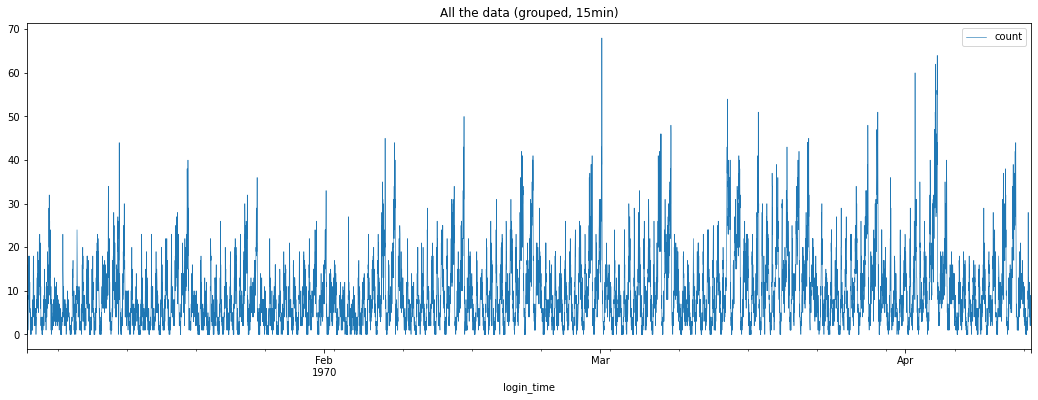

In [12]:
df_grouped.plot(y='count', figsize=(18,6), linewidth=0.6, title='All the data (grouped, 15min)');

**Note:** There is a discernable uptick in activity in the spring months. Warmer weather = more usage, generally

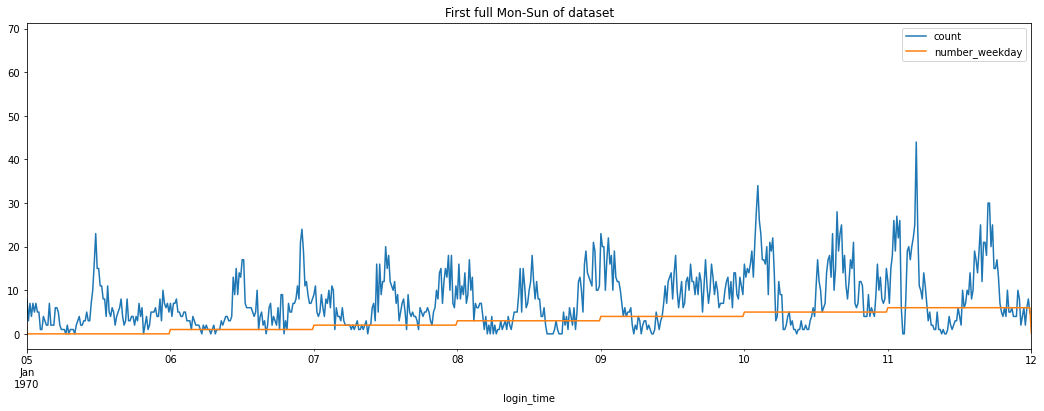

In [13]:
df_grouped.plot(figsize=(18,6), xlim=('1970-01-05 00:00:00','1970-01-12 00:00:00'),
                title='First full Mon-Sun of dataset');

**Interesting patterns in this plot:**
- The noteable spikes tend to follow an alternating pattern of 'midday' spike -> 'midnight' spike -> etc.
- Overall, usage increases as the week nears the weekend, with weekend spikes containing the weekly peaks in both categories ('midday' and 'midnight').
- Both 'midday' and 'midnight' spikes can be seen shifting later in the timeline by 1-2 hours.
 - Late night weekend usage may reflect the uptick in nightlife activity and the typically-later hours associated.
 - Later-afternoon weekend usage may reflect nightlife *in combination with* the general change in the average working person's schedule during the weekends.

In [14]:
df_grouped.loc['1970-01-02 00:00:00','weekday']

'Friday'

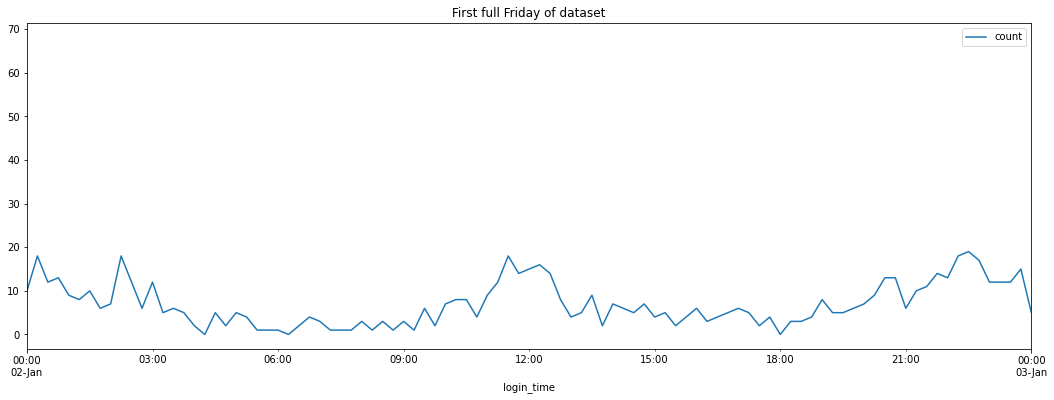

In [15]:
df_grouped.plot(y='count', figsize=(18,6), xlim=('1970-01-02 00:00:00','1970-01-03 00:00:00'),\
                title='First full Friday of dataset');

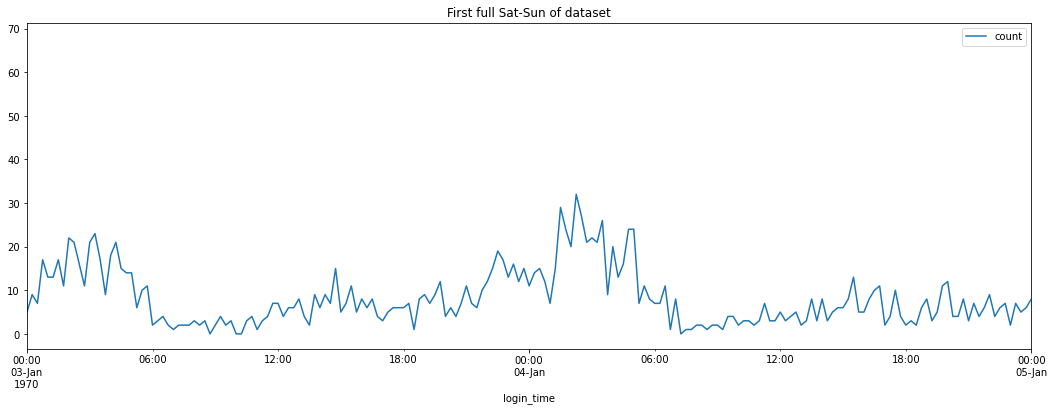

In [16]:
df_grouped.plot(y='count', figsize=(18,6), xlim=('1970-01-03 00:00:00','1970-01-05 00:00:00'),\
                title='First full Sat-Sun of dataset');

In [17]:
y = df_grouped[['count']]
y.head()

,count
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


count    0.000409
dtype: float64


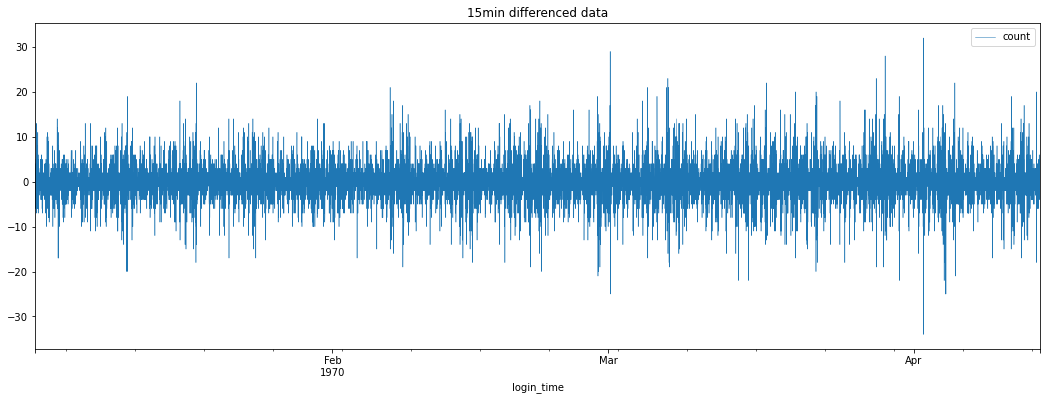

In [18]:
y_diffed = y.diff()[1:] # drop the first value of NaN
y_diffed.plot(figsize=(18,6), linewidth=0.5, title='15min differenced data');
print(y_diffed.mean())

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

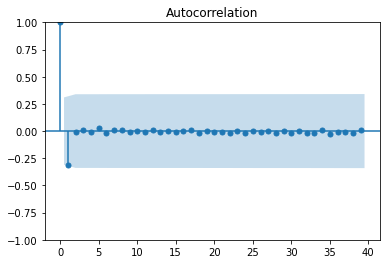

In [20]:
plot_acf(acf(y_diffed), lags=39, alpha=0.05);

*Almost* significantly *mean reverting*

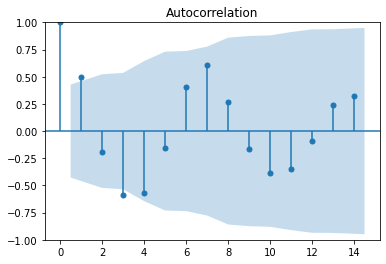

In [21]:
y_daily = y.resample(rule='D').sum()
plot_acf(acf(y_daily), alpha= 0.05);

^ Definitely seeing a weekly pattern. Exhibits some *momentum*. Autocorrelation is significant at lag 1 (day-to-day), then flips. Length of weekend may be responsible.

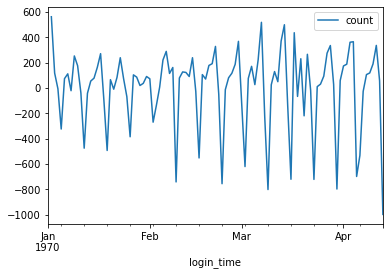

In [22]:
y_dailydiff = y.resample(rule='D').sum().diff()
y_dailydiff.plot();

**Note:** It would be valuable to know the real, physical location this data was collected at to better-understand the seasonal segmentation of the dataset in regard to weather. Appending weather data and performing a regression using the fundamentals of the data may be more appropriate than the time-series analysis.

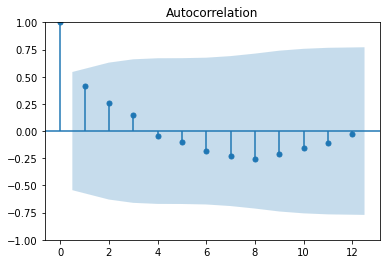

In [23]:
y_weekly = y.resample(rule='W').sum()
plot_acf(acf(y_weekly), alpha= 0.05);

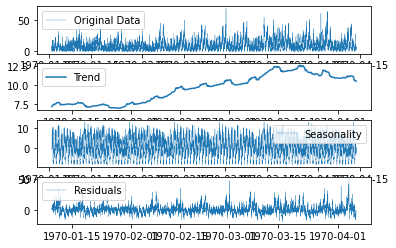

In [24]:
decomposition = seasonal_decompose(y, period=15*4*24) # Daily period decomposition

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y, label = 'Original Data', linewidth=0.3)
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', linewidth=0.3)
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals', linewidth=0.3)
plt.legend(loc = 'best')
plt.show();

# Part 2 - Experiment and Metrics Design:

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. **The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.**

# Q:

**1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

**2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

    a) how you will implement the experiment
    b) what statistical test(s) you will conduct to verify the significance of the observation
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

# A:
1) With the goal of seeing more drivers serving both cities, we could use 'average tolls reimbursed per driver' as a primary metric. This metric could be generated for past data (i.e. annual, monthly, weekly) to be compared against the new measures, in order to deliver quantitative results and perform some cost-benefit analysis. A careful analysis should be done of the change in Ultimate's specific business landscape over a year, as this could dramatically affect the accuracy of the comparison (de-trending / stationarity). The pool of drivers should also be limited to driver partners originating only from 'near-bridge' Metropolis or Gotham, so as to not downplay the effectiveness of the offering by drivers who appropriately take care of regions in the city that are far away from the bridge. Experiment with different mile-radii for pooling.

2) A/B testing could provide a good effectiveness measure. Therefore, we need a 'control' to compare against, but not necessarily in the traditional sense. A close-enough analog (i.e. prior data, another similar city-bridge-city situation) could suffice. We could also forecast for bridge tolls / target drivers, then compare our forecast to actual data for quatitative estimation of increased bridge-usage.

In [25]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(df_grouped[['count']], order=(1,1,1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 9788
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -28337.039
Date:                Fri, 12 Aug 2022   AIC                          56680.077
Time:                        16:41:00   BIC                          56701.643
Sample:                    01-01-1970   HQIC                         56687.385
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0073      0.016     -0.460      0.646      -0.038       0.024
ma.L1         -0.4243      0.014    -29.276      0.000      -0.453      -0.396
sigma2        19.1593      0.169    113.572      0.0

In [26]:
print(res.aic, res.bic)

56680.07700376448 56701.64343452476


^ A terrible model, but generally how we could model and compare A/B style

# Part 3 - Predictive Modeling:

In [27]:
# cohort of users signed up in jan2014. Classify as 'retained' if trip taken in last 30 days...
ult_df = pd.read_json('ultimate_data_challenge.json')
ult_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [28]:
ult_df.signup_date = pd.to_datetime(ult_df.signup_date)
ult_df.last_trip_date = pd.to_datetime(ult_df.last_trip_date)
ult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [29]:
ult_df.last_trip_date.min(), ult_df.last_trip_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

In [30]:
# cutoff for 'retained' is 1 month before data is pulled. Assumed here to be pulled on the date of the latest recorded trip:
cutoff = pd.to_datetime('2014-06-01 00:00:00')
cutoff

Timestamp('2014-06-01 00:00:00')

In [31]:
ult_df.loc[:,'retained'] = (ult_df.last_trip_date > cutoff).astype(int)
ult_df.iloc[:,-4:].head(10)

,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,46.2,3.67,5.0,1
1,50.0,8.26,5.0,0
2,100.0,0.77,5.0,0
3,80.0,2.36,4.9,1
4,82.4,3.13,4.9,0
5,100.0,10.56,5.0,1
6,100.0,3.95,4.0,0
7,100.0,2.04,5.0,0
8,100.0,4.36,5.0,0
9,0.0,2.37,5.0,0


In [32]:
ult_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.00000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.36620
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.48177
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.00000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.00000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.00000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.00000


In [33]:
print('looks like a customer retention of ~', round(100*ult_df.describe().loc['mean',:]['retained'], 2), 'in the dataset')

looks like a customer retention of ~ 36.62 in the dataset


**^ ^ ^**

# Do ML:

In [34]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # Going with LR as a decent baseline estimator
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [35]:
print(ult_df.shape)
ult_df = ult_df.dropna()
# For simplicity here, dropping NaNs
# Future scope: would explore imputing missing vals as 'average' or 'most frequent', etc.
print(ult_df.shape)
print(100*(50000-41744)/50000,'percent of rows lost with .dropna()')

(50000, 13)
(41445, 13)
16.512 percent of rows lost with .dropna()


In [36]:
X_ml = ult_df.drop(columns='retained')
y_ml = ult_df[['retained']].values

y_ml[:5]

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [37]:
X_ml.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [38]:
print(X_ml.shape)
X_ml = pd.get_dummies(X_ml)
print(X_ml.shape)
X_ml.head()

(41445, 12)
(41445, 15)


,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0


In [39]:
X_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  41445 non-null  int64         
 1   signup_date             41445 non-null  datetime64[ns]
 2   avg_rating_of_driver    41445 non-null  float64       
 3   avg_surge               41445 non-null  float64       
 4   last_trip_date          41445 non-null  datetime64[ns]
 5   surge_pct               41445 non-null  float64       
 6   ultimate_black_user     41445 non-null  bool          
 7   weekday_pct             41445 non-null  float64       
 8   avg_dist                41445 non-null  float64       
 9   avg_rating_by_driver    41445 non-null  float64       
 10  city_Astapor            41445 non-null  uint8         
 11  city_King's Landing     41445 non-null  uint8         
 12  city_Winterfell         41445 non-null  uint8 

In [40]:
numerics = X_ml.drop(columns=['signup_date','last_trip_date','city_Astapor',
                              "city_King's Landing",'city_Winterfell','phone_Android','phone_iPhone'])
numerics.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [41]:
scaler = StandardScaler()
X_ml.loc[:, numerics.columns] = scaler.fit_transform(numerics)
X_ml.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,0.342505,2014-01-25,0.159520,0.131718,2014-06-17,0.354838,1.266291,-0.432445,-0.347912,0.552529,0,1,0,0,1
1,-0.642890,2014-01-29,0.646456,-0.371440,2014-05-05,-0.485689,-0.789708,-0.323292,0.544197,0.552529,1,0,0,1,0
2,0.096156,2014-01-06,-0.489729,-0.371440,2014-01-07,-0.485689,-0.789708,1.112936,-0.911554,0.552529,1,0,0,0,1
3,1.574248,2014-01-10,-0.002792,0.332981,2014-06-29,0.605905,1.266291,0.538445,-0.602523,0.305372,0,1,0,0,1
4,2.805992,2014-01-27,-0.327417,0.584560,2014-03-15,0.158351,-0.789708,0.607384,-0.452866,0.305372,0,0,1,1,0


In [42]:
X_ml = X_ml.drop(columns=['signup_date', 'last_trip_date'])
# Cols deemed insignificant for our classification purposes.
# No additional encoding done, just dropped for now. Future scope: could revisit for tuning

In [43]:
X_tr, X_te, y_tr, y_te = train_test_split(X_ml, y_ml.ravel(), train_size=.8, 
                                          stratify=y_ml, random_state=42)
(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

((33156, 13), (8289, 13), (33156,), (8289,))

In [44]:
lr = LogisticRegression(solver='saga') # 'saga' to allow us to check l1 vs l2 and more, if desired

param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1]}

grid_lr = GridSearchCV(lr, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

In [45]:
grid_lr.fit(X_tr, y_tr)

print(grid_lr.best_params_)

best_lr = grid_lr.best_estimator_

{'C': 0.1, 'penalty': 'l1'}


In [46]:
y_pred = best_lr.predict(X_te)

print('roc_auc:',roc_auc_score(y_te, y_pred))
print(classification_report(y_te, y_pred))

roc_auc: 0.688169189377162
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      4967
           1       0.68      0.55      0.61      3322

    accuracy                           0.72      8289
   macro avg       0.71      0.69      0.69      8289
weighted avg       0.71      0.72      0.71      8289



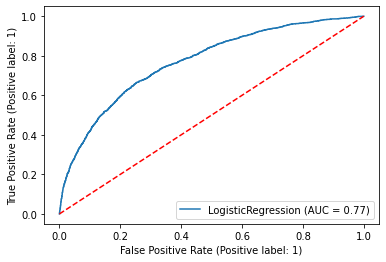

In [47]:
warnings.simplefilter(action='ignore', category= FutureWarning)

_ = plot_roc_curve(best_lr, X_te, y_te, pos_label=1)
plt.plot([0, 1], [0, 1], 'r--')
plt.show();

**^ Decent metrics for relatively out-of-the-box approach**

In [48]:
features = X_ml.keys()
imp = best_lr.coef_.ravel()
imp_df = pd.DataFrame((zip(features, imp)), columns =['Features', 'Importance scores'])
imp_df = imp_df.sort_values('Importance scores', ascending=False)
print(imp_df)

                  Features  Importance scores
9      city_King's Landing           1.177625
4      ultimate_black_user           0.452301
0   trips_in_first_30_days           0.426889
12            phone_iPhone           0.312327
3                surge_pct           0.065832
5              weekday_pct           0.033880
10         city_Winterfell           0.000000
2                avg_surge          -0.034286
1     avg_rating_of_driver          -0.038047
7     avg_rating_by_driver          -0.095357
6                 avg_dist          -0.189964
8             city_Astapor          -0.561669
11           phone_Android          -0.835925


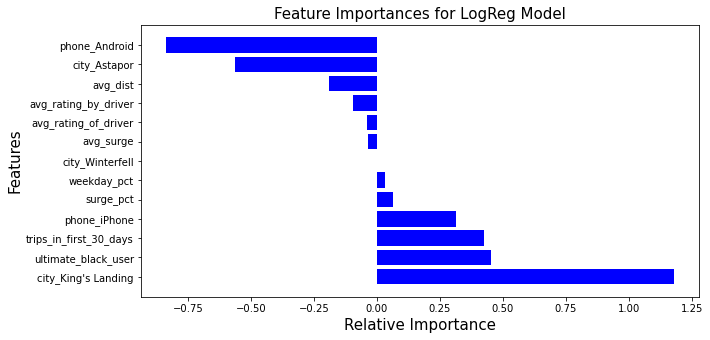

In [49]:
plt.figure(figsize=(10,5))
_=plt.barh(imp_df['Features'], imp_df['Importance scores'], align='center', color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for LogReg Model',fontsize=15)
plt.yticks(imp_df['Features'], imp_df['Features'])
plt.show();

# Conclusions:

Clearly, users in **King's Landing** have alot of use for our services, while those in Astapor don't. Additionally, if one is subscribed as an **'Ultimate black' user**, they will likely be retained, which seems sensible. Usage in the **first 30 days** seems to be an indicator of retention. Also, **Iphone users** are much more active than Android users on our platform. Weekday% and Surge% importances indicate **commuters** and **those who pay 'surge' prices** are more likely to be active users. Finally, it seems that active users *are more discrete in their driver ratings*, and drivers *rate less-engaged users better, on average, than active ones.* This may be due to 'loss of novelty' with engaged users, leading to a less enjoyable, but not necessarily unpleasant, experience for the *drivers*. (speculation)

**For suggestions:**
- Develop a promotion that gets people using the app for the first 30 days. ('first 30 days, no service fee', 'first 30 days, XX% off!', etc.).
- Also, market heavily in King's Landing, as well as to iPhone users for efficacy.
- Consider making the app more appealing to Android users and structure marketing around "new and improved" / "Now more Android friendly" or something along those lines.